# Cross Selling Groceries
# Load Necessary Dependencies

In [3]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import Orange
from Orange.data import Domain, DiscreteVariable, ContinuousVariable
from orangecontrib.associate.fpgrowth import *

%matplotlib inline

# Construct and Load the Groceries Dataset

In [4]:
grocery_items = set()
with open("data/grocery_dataset.txt") as f:
    reader = csv.reader(f, delimiter=",")
    for i, line in enumerate(reader):
        grocery_items.update(line)
output_list = list()
with open("data/grocery_dataset.txt") as f:
    reader = csv.reader(f, delimiter=",")
    for i, line in enumerate(reader):
        row_val = {item:0 for item in grocery_items}
        row_val.update({item:1 for item in line})
        output_list.append(row_val)
grocery_df = pd.DataFrame(output_list)

In [5]:
grocery_df.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# View top sold items

In [6]:
total_item_count = sum(grocery_df.sum())
print(total_item_count)
item_summary_df = grocery_df.sum().sort_values(ascending = False).reset_index().head(n=20)
item_summary_df.rename(columns={item_summary_df.columns[0]:'item_name',item_summary_df.columns[1]:'item_count'}, inplace=True)
item_summary_df.head()

43367


,item_name,item_count
0,whole milk,2513
1,other vegetables,1903
2,rolls/buns,1809
3,soda,1715
4,yogurt,1372


# Visualize top sold items

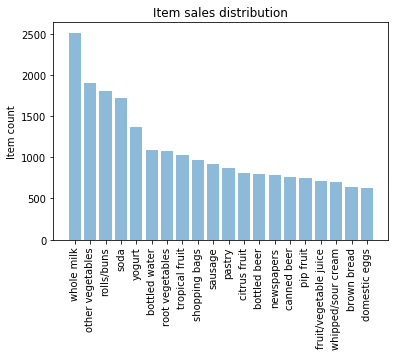

In [7]:
objects = (list(item_summary_df['item_name'].head(n=20)))
y_pos = np.arange(len(objects))
performance = list(item_summary_df['item_count'].head(n=20))
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Item count')
plt.title('Item sales distribution');

# Analyze items contributing to top sales

In [8]:
item_summary_df['item_perc'] = item_summary_df['item_count']/total_item_count
item_summary_df['total_perc'] = item_summary_df.item_perc.cumsum()
item_summary_df.head(10)

,item_name,item_count,item_perc,total_perc
0,whole milk,2513,0.057947,0.057947
1,other vegetables,1903,0.043881,0.101829
2,rolls/buns,1809,0.041714,0.143542
3,soda,1715,0.039546,0.183089
4,yogurt,1372,0.031637,0.214725
5,bottled water,1087,0.025065,0.239791
6,root vegetables,1072,0.024719,0.264510
7,tropical fruit,1032,0.023797,0.288307
8,shopping bags,969,0.022344,0.310651
9,sausage,924,0.021307,0.331957


# Analyze items contributing to top 50% of sales

In [9]:
item_summary_df[item_summary_df.total_perc <= 0.5].shape

(19, 4)

In [10]:
item_summary_df[item_summary_df.total_perc <= 0.5]

,item_name,item_count,item_perc,total_perc
0,whole milk,2513,0.057947,0.057947
1,other vegetables,1903,0.043881,0.101829
2,rolls/buns,1809,0.041714,0.143542
3,soda,1715,0.039546,0.183089
4,yogurt,1372,0.031637,0.214725
5,bottled water,1087,0.025065,0.239791
6,root vegetables,1072,0.024719,0.264510
7,tropical fruit,1032,0.023797,0.288307
8,shopping bags,969,0.022344,0.310651
9,sausage,924,0.021307,0.331957


# Construct Orange Table 

In [11]:
input_assoc_rules = grocery_df
domain_grocery = Domain([DiscreteVariable.make(name=item,values=['0', '1']) for item in input_assoc_rules.columns])
data_gro_1 = Orange.data.Table.from_numpy(domain=domain_grocery,  X=input_assoc_rules.as_matrix(),Y= None)

/Users/adhiman/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


# Prune Dataset for frequently purchased items

In [12]:
def prune_dataset(input_df, length_trans = 2, total_sales_perc = 0.5, start_item = None, end_item = None):
    if 'total_items' in input_df.columns:
        del(input_df['total_items'])
    item_count = input_df.sum().sort_values(ascending = False).reset_index()
    total_items = sum(input_df.sum().sort_values(ascending = False))
    item_count.rename(columns={item_count.columns[0]:'item_name',item_count.columns[1]:'item_count'}, inplace=True)
    if not start_item and not end_item: 
        item_count['item_perc'] = item_count['item_count']/total_items
        item_count['total_perc'] = item_count.item_perc.cumsum()
        selected_items = list(item_count[item_count.total_perc < total_sales_perc].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items], item_count[item_count.total_perc < total_sales_perc]
    elif end_item > start_item:
        selected_items = list(item_count[start_item:end_item].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items],item_count[start_item:end_item]

In [13]:
output_df, item_counts = prune_dataset(input_df=grocery_df, length_trans=2,total_sales_perc=0.4)
print(output_df.shape)
print(list(output_df.columns))

(4585, 13)
['whole milk', 'other vegetables', 'rolls/buns', 'soda', 'yogurt', 'bottled water', 'root vegetables', 'tropical fruit', 'shopping bags', 'sausage', 'pastry', 'citrus fruit', 'bottled beer']


# Association Rule Mining with FP Growth

In [14]:
input_assoc_rules = output_df
domain_grocery = Domain([DiscreteVariable.make(name=item,values=['0', '1']) for item in input_assoc_rules.columns])
data_gro_1 = Orange.data.Table.from_numpy(domain=domain_grocery,  X=input_assoc_rules.as_matrix(),Y= None)
data_gro_1_en, mapping = OneHot.encode(data_gro_1, include_class=False)

/Users/adhiman/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
min_support = 0.01
print("num of required transactions = ", int(input_assoc_rules.shape[0]*min_support))
num_trans = input_assoc_rules.shape[0]*min_support
itemsets = dict(frequent_itemsets(data_gro_1_en, min_support=min_support))

num of required transactions =  45


In [16]:
len(itemsets)

166886

In [17]:
confidence = 0.3
rules_df = pd.DataFrame()

if len(itemsets) < 1000000: 
    rules = [(P, Q, supp, conf)
    for P, Q, supp, conf in association_rules(itemsets, confidence)
       if len(Q) == 1 ]

    names = {item: '{}={}'.format(var.name, val)
        for item, var, val in OneHot.decode(mapping, data_gro_1, mapping)}
    
    eligible_ante = [v for k,v in names.items() if v.endswith("1")]
    
    N = input_assoc_rules.shape[0]
    
    rule_stats = list(rules_stats(rules, itemsets, N))
    
    rule_list_df = []
    for ex_rule_frm_rule_stat in rule_stats:
        ante = ex_rule_frm_rule_stat[0]            
        cons = ex_rule_frm_rule_stat[1]
        named_cons = names[next(iter(cons))]
        if named_cons in eligible_ante:
            rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
            ante_rule = ', '.join(rule_lhs)
            if ante_rule and len(rule_lhs)>1 :
                rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                             'confidence' : ex_rule_frm_rule_stat[3],
                             'coverage' : ex_rule_frm_rule_stat[4],
                             'strength' : ex_rule_frm_rule_stat[5],
                             'lift' : ex_rule_frm_rule_stat[6],
                             'leverage' : ex_rule_frm_rule_stat[7],
                             'antecedent': ante_rule,
                             'consequent':named_cons[:-2] }
                rule_list_df.append(rule_dict)
    rules_df = pd.DataFrame(rule_list_df)
    print("Raw rules data frame of {} rules generated".format(rules_df.shape[0]))
    if not rules_df.empty:
        pruned_rules_df = rules_df.groupby(['antecedent','consequent']).max().reset_index()
    else:
        print("Unable to generate any rule")

Raw rules data frame of 16628 rules generated


# Sorting rules in our Grocery Dataset

In [18]:
(pruned_rules_df[['antecedent','consequent',
                  'support','confidence','lift']].groupby('consequent')
                                                 .max()
                                                 .reset_index()
                                                 .sort_values(['lift', 'support','confidence'],
                                                              ascending=False))

,consequent,antecedent,support,confidence,lift
4,root vegetables,"yogurt, tropical fruit",228,0.463636,2.230611
5,sausage,"shopping bags, rolls/buns",59,0.393162,2.201037
8,tropical fruit,"yogurt, root vegetables",92,0.429907,2.156588
1,citrus fruit,"whole milk, other vegetables, tropical fruit",66,0.333333,2.125637
10,yogurt,"whole milk, tropical fruit",199,0.484211,1.891061
2,other vegetables,"yogurt, whole milk, tropical fruit",228,0.643836,1.826724
6,shopping bags,"soda, sausage",50,0.304878,1.782992
0,bottled water,"yogurt, soda",59,0.333333,1.707635
9,whole milk,"yogurt, tropical fruit",228,0.754098,1.703222
3,rolls/buns,"yogurt, tropical fruit",97,0.522222,1.679095


# Association rule mining on our Online Retail dataset

## Load and Filter Dataset

In [20]:
cs_mba = pd.read_excel(io=r'data/Online Retail.xlsx')
cs_mba_uk = cs_mba[cs_mba.Country == 'United Kingdom']

In [21]:
cs_mba_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Remove returned item as we are only interested in the buying patterns

In [22]:
cs_mba_uk = cs_mba_uk[~(cs_mba_uk.InvoiceNo.str.contains("C") == True)]
cs_mba_uk = cs_mba_uk[~cs_mba_uk.Quantity<0]

In [23]:
cs_mba_uk.shape

(486286, 8)

In [24]:
cs_mba_uk.InvoiceNo.value_counts().shape

(18786,)

## Build Transaction Dataset

In [25]:
items = list(cs_mba_uk.Description.unique())
grouped = cs_mba_uk.groupby('InvoiceNo')
transaction_level_df_uk = grouped.aggregate(lambda x: tuple(x)).reset_index()[['InvoiceNo','Description']]

In [26]:
transaction_dict = {item:0 for item in items}
output_dict = dict()
temp = dict()
for rec in transaction_level_df_uk.to_dict('records'):
    invoice_num = rec['InvoiceNo']
    items_list = rec['Description']
    transaction_dict = {item:0 for item in items}
    transaction_dict.update({item:1 for item in items if item in items_list})
    temp.update({invoice_num:transaction_dict})

new = [v for k,v in temp.items()]
tranasction_df = pd.DataFrame(new)
del(tranasction_df[tranasction_df.columns[0]])

In [27]:
tranasction_df.shape

(18786, 4058)

In [28]:
tranasction_df.head()

,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,5 HOOK HANGER MAGIC TOADSTOOL,60 TEATIME FAIRY CAKE CASES,"AIRLINE LOUNGE,METAL SIGN",ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE IVORY,ALARM CLOCK BAKELIKE ORANGE,ALARM CLOCK BAKELIKE RED,ANTIQUE GLASS DRESSING TABLE POT,...,SET OF 6 RIBBONS COUNTRY STYLE,SNACK TRAY RED VINTAGE DOILY,SET OF 6 RIBBONS PERFECTLY PRETTY,SET OF 6 RIBBONS PARTY,SET 10 CARDS SNOWY ROBIN 17099,SET 10 CARDS SWIRLY XMAS TREE 17104,"LETTER ""U"" BLING KEY RING",CREAM HANGING HEART T-LIGHT HOLDER,BLACK SIL'T SQU CANDLE PLATE,"PAPER CRAFT , LITTLE BIRDIE"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
output_df_uk_n, item_counts_n = prune_dataset(input_df=tranasction_df, length_trans=2, start_item=0, end_item=15)
print(output_df_uk_n.shape)

(4961, 15)


In [30]:
output_df_uk_n.head()

,WHITE HANGING HEART T-LIGHT HOLDER,JUMBO BAG RED RETROSPOT,REGENCY CAKESTAND 3 TIER,PARTY BUNTING,LUNCH BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,SET OF 3 CAKE TINS PANTRY DESIGN,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG BLACK SKULL.,HEART OF WICKER SMALL,JUMBO BAG PINK POLKADOT,JUMBO SHOPPER VINTAGE RED PAISLEY,JUMBO STORAGE BAG SUKI,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS
12,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0
14,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
16,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
21,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


## Association Rule Mining with FP Growth

In [31]:
input_assoc_rules = output_df_uk_n
domain_transac = Domain([DiscreteVariable.make(name=item,values=['0', '1']) for item in input_assoc_rules.columns])
data_tran_uk = Orange.data.Table.from_numpy(domain=domain_transac,  X=input_assoc_rules.as_matrix(),Y= None)
data_tran_uk_en, mapping = OneHot.encode(data_tran_uk, include_class=True)

/Users/adhiman/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
support = 0.01
print("num of required transactions = ", int(input_assoc_rules.shape[0]*support))
num_trans = input_assoc_rules.shape[0]*support
itemsets = dict(frequent_itemsets(data_tran_uk_en, support))

num of required transactions =  49


In [33]:
len(itemsets)

645632

In [34]:
confidence = 0.3
rules_df = pd.DataFrame()
if len(itemsets) < 1000000: 
    rules = [(P, Q, supp, conf)
    for P, Q, supp, conf in association_rules(itemsets, confidence)
       if len(Q) == 1 ]

    names = {item: '{}={}'.format(var.name, val)
        for item, var, val in OneHot.decode(mapping, data_tran_uk, mapping)}
    
    eligible_ante = [v for k,v in names.items() if v.endswith("1")]
    
    N = input_assoc_rules.shape[0]
    
    rule_stats = list(rules_stats(rules, itemsets, N))
    
    rule_list_df = []
    for ex_rule_frm_rule_stat in rule_stats:
        ante = ex_rule_frm_rule_stat[0]            
        cons = ex_rule_frm_rule_stat[1]
        named_cons = names[next(iter(cons))]
        if named_cons in eligible_ante:
            rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
            ante_rule = ', '.join(rule_lhs)
            if ante_rule and len(rule_lhs)>1 :
                rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                             'confidence' : ex_rule_frm_rule_stat[3],
                             'coverage' : ex_rule_frm_rule_stat[4],
                             'strength' : ex_rule_frm_rule_stat[5],
                             'lift' : ex_rule_frm_rule_stat[6],
                             'leverage' : ex_rule_frm_rule_stat[7],
                             'antecedent': ante_rule,
                             'consequent':named_cons[:-2] }
                rule_list_df.append(rule_dict)
    rules_df = pd.DataFrame(rule_list_df)
    print("Raw rules data frame of {} rules generated".format(rules_df.shape[0]))
    if not rules_df.empty:
        pruned_rules_df = rules_df.groupby(['antecedent','consequent']).max().reset_index()
    else:
        print("Unable to generate any rule")

Raw rules data frame of 117464 rules generated


## Sort and display rules

In [35]:
dw = pd.options.display.max_colwidth
pd.options.display.max_colwidth = 100
(pruned_rules_df[['antecedent','consequent',
                  'support','confidence','lift']].groupby('consequent')
                                                 .max()
                                                 .reset_index()
                                                 .sort_values(['lift', 'support','confidence'],
                                                              ascending=False)).head(5)

,consequent,antecedent,support,confidence,lift
8,PACK OF 72 RETROSPOT CAKE CASES,"WHITE HANGING HEART T-LIGHT HOLDER, REGENCY CAKESTAND 3 TIER, NATURAL SLATE HEART CHALKBOARD",145,0.971014,5.394404
9,PAPER CHAIN KIT 50'S CHRISTMAS,"WHITE HANGING HEART T-LIGHT HOLDER, REGENCY CAKESTAND 3 TIER, NATURAL SLATE HEART CHALKBOARD",94,0.597701,4.341428
3,JUMBO SHOPPER VINTAGE RED PAISLEY,"WHITE HANGING HEART T-LIGHT HOLDER, PAPER CHAIN KIT 50'S CHRISTMAS",384,0.879310,4.218819
5,LUNCH BAG BLACK SKULL.,"WHITE HANGING HEART T-LIGHT HOLDER, PACK OF 72 RETROSPOT CAKE CASES, LUNCH BAG RED RETROSPOT",227,0.852459,4.078157
4,JUMBO STORAGE BAG SUKI,"WHITE HANGING HEART T-LIGHT HOLDER, SET OF 3 CAKE TINS PANTRY DESIGN , JUMBO BAG PINK POLKADOT",405,0.852459,4.016191


In [36]:
pd.options.display.max_colwidth = dw